# Initialization

## Import of useful modules:

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

from time import sleep, monotonic, time


import qcodes as qc
from qcodes import Parameter
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

# sys.path.append('M:\\tnw\\ns\\qt\\2D Topo\\code\\qcodes')
sys.path.append('C:\\qcodes')
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

In [3]:
fridge_name = 'BF1'
# %run ..\..\..\..\..\code\qcodes\init_fridge.py {fridge_name}
%run C:\qcodes\init_fridge.py {fridge_name}

Connected to: Stanford_Research_Systems SR860 (serial:004608, firmware:V1.51) in 0.05s


## Zero dacs and lockin

In [4]:
# ivvi.set_dacs_zero()
lockin_1.amplitude(1)


In [5]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import OrderedDict
from scipy.interpolate import make_interp_spline
plt.rcParams['font.sans-serif'] = ['DFKai-SB'] 
plt.rcParams['axes.unicode_minus'] = False
linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [6]:
import pandas as pd
# from openpyxl import Workbook

In [7]:
set_resistance = 10e6
set_V_amp = lockin_1.amplitude()
set_current = set_V_amp/set_resistance


In [8]:
def mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f):
    t =lockin_1.time_constant( ) #set sleep times
    tim_fre = int((set_end_f-set_sat_f-1)/step_fre)
    fre_x = np.zeros(step_fre+1)
    V_sap_y = np.zeros(step_fre+1)
    R_sap_y = np.zeros(step_fre+1)
    idex = 0
    lockin_1.frequency(1)
    sleep(1)
    for i in range(set_sat_f, set_end_f, tim_fre):
        if i == 1:
            idex += 1
            
        elif i>1 and i< int(5e5):
            if idex < len(fre_x):
                fre_x[idex] = i+idex-1
                lockin_1.frequency(i+idex-1)
        
                V_sap_y[idex] = lockin_1.R()
                sleep(t)
                idex += 1
            
        else:
            print("f >500 KHz")
            break
    dbm_V = 20*np.log10(V_sap_y)
    dbm_V[0] = 0
    dbm_V[1] = 0
    # for i in range(0, 10):
    #     if  dbm_V[i] > 0:
    #         dbm_V[i] = dbm_V[i+1]
    return fre_x, dbm_V

In [9]:
def mes_V_to_f_value(step_fre, set_sat_f, set_end_f):
    t =lockin_1.time_constant( ) #set sleep times
    tim_fre = int((set_end_f-set_sat_f-1)/step_fre)
    fre_x = np.zeros(step_fre+1)
    V_sap_y = np.zeros(step_fre+1)
    R_sap_y = np.zeros(step_fre+1)
    idex = 0
    lockin_1.frequency(1)
    sleep(1)
    for i in range(set_sat_f, set_end_f, tim_fre):
        if i == 1:
            idex += 1
            
        elif i>1 and i< int(5e5):
            if idex < len(fre_x):
                fre_x[idex] = i+idex-1
                lockin_1.frequency(i+idex-1)
        
                V_sap_y[idex] = lockin_1.R()
                sleep(t)
                idex += 1
            
        else:
            print("f >500 KHz")
            break

    return fre_x, V_sap_y

In [10]:
# find -3dBm frequency
def closest_value(list_a, k):
    arr = list_a
    ids = (np.abs(arr - k)).argmin()
    return arr[ids] , ids

In [51]:
# mes 10 time to avg
set_sat_f = int(1)
set_end_f = int(8e4) # max frequency 5e5
step_fre = 1000 # set point you want




# avg_fre = np.zeros(10)


# for i in range (1,11):
    
#     V_TO_f = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
#     dBm3_fre = closest_value(V_TO_f[1], k)
#     avg_fre[i-1] = V_TO_f[0].tolist()[dBm3_fre[1]]
# print(np.average(avg_fre))

V_TO_f = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
# set -3dBm V
k = -3

dBm3_fre = closest_value(V_TO_f[1], k)
print(V_TO_f[0].tolist()[dBm3_fre[1]])
# print(dBm3_fre)

10080.0


In [66]:
set_sat_f = int(1)
set_end_f = int(8e4) # max frequency 5e5
step_fre = 2000 # set point you want
k = -3

In [16]:
# for low pass
low_V_f = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
low_dBm3 = closest_value(low_V_f[1], k)
print(low_V_f[0].tolist()[low_dBm3[1]])

16000.0


In [20]:
# for low pass ---- 100ohm ---- 100nF
low_V_f_100 = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
low_dBm3_100 = closest_value(low_V_f_100[1], k)
print(low_V_f_100[0].tolist()[low_dBm3_100[1]])

12160.0


In [31]:
# for T pass
T_V_f = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
T_dBm3 = closest_value(T_V_f[1], k)
print(T_V_f[0].tolist()[T_dBm3[1]])

15640.0


In [33]:
# for T pass ---- 100ohm ---- 100nF
T_V_f_100 = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
T_dBm3_100 = closest_value(T_V_f_100[1], k)
print(T_V_f_100[0].tolist()[T_dBm3_100[1]])

11240.0


In [36]:
# for pi pass
pi_V_f = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
pi_dBm3 = closest_value(pi_V_f[1], k)
print(pi_V_f[0].tolist()[pi_dBm3[1]])

15320.0


In [71]:
# for pi pass ---- 100ohm ---- 100nF
pi_V_f_100 = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
pi_dBm3_100 = closest_value(pi_V_f_100[1], k)
print(pi_V_f_100[0].tolist()[pi_dBm3_100[1]])
avg_fre = np.zeros(10)


# for i in range (1,11):
    
#     pi_V_f_100 = mes_Vdb_to_f_value(step_fre, set_sat_f, set_end_f)
#     pi_dBm3_100 = closest_value(pi_V_f_100[1], k)
#     avg_fre[i-1] = pi_V_f_100[0].tolist()[pi_dBm3_100[1]]
# print(np.average(avg_fre))


9960.0


In [57]:
columns = ['x',
            'low_V_f',
           'low_V_f_100',
           'T_V_f',
           'T_V_f_100',
           'pi_V_f',
           'pi_V_f_100'
          ]

In [65]:
len(pi_V_f_100[1])

1001

In [72]:
df = pd.DataFrame(list(zip(low_V_f[0],
                           low_V_f[1],
                           low_V_f_100[1],
                           T_V_f[1],
                           T_V_f_100[1],
                           pi_V_f[1],
                           pi_V_f_100[1]
                            )), columns=columns)

df.to_csv(r'out4.csv')
df

,x,low_V_f,low_V_f_100,T_V_f,T_V_f_100,pi_V_f,pi_V_f_100
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,40.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,80.0,0.101933,0.040104,-0.794416,-0.215920,0.048818,0.359682
3,120.0,-0.069578,0.097356,-0.530484,0.119693,0.351025,-0.136523
4,160.0,0.273147,0.043411,-0.182153,0.029019,0.046201,0.036630
...,...,...,...,...,...,...,...
1996,79840.0,-13.972291,-14.934244,-14.245367,-15.480185,-14.549243,-19.952332
1997,79880.0,-13.976519,-14.938033,-14.249850,-15.484321,-14.552882,-19.958882
1998,79920.0,-13.979736,-14.942346,-14.254237,-15.488476,-14.557104,-19.965177
1999,79960.0,-13.984141,-14.946565,-14.258049,-15.492457,-14.561529,-19.971692


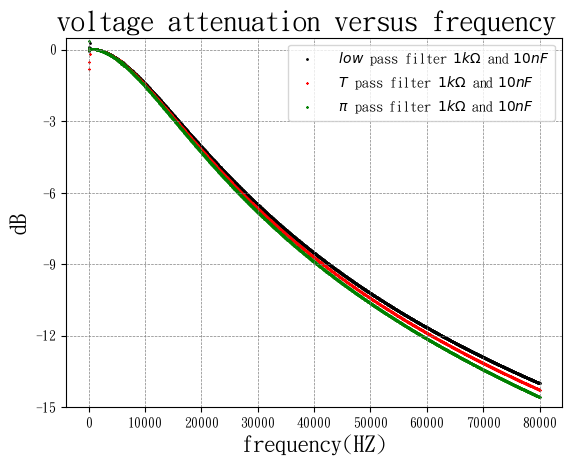

In [47]:


fig, ax= plt.subplots()

ax.set(xlabel = 'frequency(HZ)', ylabel = 'dB', 
       title = "voltage attenuation versus frequency ")  
ax.title.set_size(20)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_ylim(int(pi_V_f[1].min())-0.5, int(pi_V_f[1].max())+0.5)
# plt.yticks(np.linspace(int(pi_V_f[1].min())-1, 0, -int(pi_V_f[1].min())+2))

plt.yticks(np.linspace(-15, 0, 6))
# for low pass

ax.scatter(low_V_f[0],
            low_V_f[1],
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $low$ pass filter $1k\Omega$ and$\ 10nF $",
            marker = "o")
# for T pass

ax.scatter(T_V_f[0],
            T_V_f[1],
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $T$ pass filter $1k\Omega$ and$\ 10nF $",
            marker = "x")

# for pi pass

ax.scatter(pi_V_f[0],
            pi_V_f[1],
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $\pi$ pass filter $1k\Omega$ and$\ 10nF $",
            marker = "*")


plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.savefig('C:\\qcodes\\personal_scripts\\HE\\filter\only_filter\\aa.png', 
            dpi=200, 
            format='png')
plt.show()

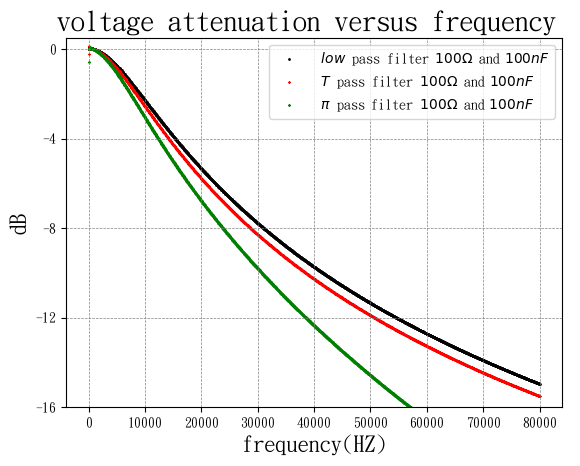

In [69]:
fig, ax= plt.subplots()

ax.set(xlabel = 'frequency(HZ)', ylabel = 'dB', 
       title = "voltage attenuation versus frequency ")  
ax.title.set_size(20)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_ylim(int(pi_V_f[1].min())-0.5, int(pi_V_f[1].max())+0.5)
# plt.yticks(np.linspace(int(pi_V_f[1].min())-1, 0, -int(pi_V_f[1].min())+2))

plt.yticks(np.linspace(-16, 0, 5))
# for low pass

ax.scatter(low_V_f_100[0],
            low_V_f_100[1],
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $low$ pass filter $100\Omega$ and$\ 100nF $",
            marker = "o")
# for T pass

ax.scatter(T_V_f_100[0],
            T_V_f_100[1],
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $T$ pass filter $100\Omega$ and$\ 100nF $",
            marker = "x")

# for pi pass

ax.scatter(pi_V_f_100[0],
            pi_V_f_100[1],
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $\pi$ pass filter $100\Omega$ and$\ 100nF $",
            marker = "*")


plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
# plt.savefig('C:\\qcodes\\personal_scripts\\HE\\filter\only_filter\\aaa.png', 
#             dpi=200, 
#             format='png')
plt.show()

In [288]:
#for R
set_sat_f = int(1)
set_end_f = int(5e5) # max frequency 5e5
step_fre = 10000 # set point you want
# v_i = lockin_1.amplitude()

set_resistance = 10e6
set_V_amp = lockin_1.amplitude()
set_current = set_V_amp/set_resistance

In [10]:
lockin_1.amplitude()

1.0

In [ ]:
#for R

v_o = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
R_s = v_o[1]/set_current

In [52]:
#for low pass 10ohm --1k ver 10nF

# low_10_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_low_10_1 = low_10_1[1]/set_current

In [79]:
#for low pass 100ohm --1k ver 10nF

# low_100_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_low_100_1 = low_100_1[1]/set_current

In [73]:
#for low pass 10Mohm --1k ver 10nF

# low_10M_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_low_10M_1 = low_10M_1[1]/set_current

In [85]:
#for low pass 10ohm --100 ver 100nF

# low_10_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_low_10_100 = low_10_100[1]/set_current

In [88]:
#for low pass 100ohm --100 ver 100nF

# low_100_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_low_100_100 = low_100_100[1]/set_current

In [94]:
#for low pass 10Mohm --100 ver 100nF

# low_10M_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_low_10M_100 = low_10M_100[1]/set_current

In [96]:
#for T pass 10ohm --1k ver 10nF

# T_10_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_T_10_1 = T_10_1[1]/set_current

In [107]:
#for T pass 100ohm --1k ver 10nF

# T_100_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_T_100_1 = T_100_1[1]/set_current

In [109]:
#for T pass 10Mohm --1k ver 10nF

# T_10M_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_T_10M_1 = T_10M_1[1]/set_current

In [111]:
#for T pass 10ohm --100 ver 100nF

# T_10_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_T_10_100 = T_10_100[1]/set_current

In [115]:
#for T pass 100ohm --100 ver 100nF

# T_100_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_T_100_100 = T_100_100[1]/set_current

In [118]:
#for T pass 10Mohm --100 ver 100nF

# T_10M_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_T_10M_100 =T_10M_100[1]/set_current

In [152]:
#for pi pass 10ohm --1k ver 10nF

# pi_10_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_pi_10_1 = pi_10_1[1]/set_current

In [156]:
#for pi pass 100ohm --1k ver 10nF

# pi_100_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_pi_100_1 = pi_100_1[1]/set_current

In [165]:
#for pi pass 10Mohm --1k ver 10nF

# pi_10M_1 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_pi_10M_1 = pi_10M_1[1]/set_current

In [176]:
#for pi pass 10ohm --100 ver 100nF

# pi_10_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_pi_10_100 =pi_10_100[1]/set_current

In [178]:
#for pi pass 100ohm --100 ver 100nF

# pi_100_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_pi_100_100 = pi_100_100[1]/set_current

In [180]:
#for pi pass 10Mohm --100 ver 100nF

# pi_10M_100 = mes_V_to_f_value(step_fre, set_sat_f, set_end_f)
# R_pi_10M_100 =pi_10M_100[1]/set_current

In [188]:
columns = ['R_low_10_1', 'R_low_100_1', 'R_low_10M_1', 'R_low_10_100', 'R_low_100_100', 'R_low_10M_100', 'R_T_10_1', 'R_T_100_1', 'R_T_10M_1', 'R_T_10_100', 'R_T_100_100','R_T_10M_100','R_pi_10_1','R_pi_100_1','R_pi_10M_1','R_pi_10_100','R_pi_100_100','R_pi_10M_100']

In [189]:
df = pd.DataFrame(list(zip(R_low_10_1,
                           R_low_100_1,
                           R_low_10M_1,
                           R_low_10_100,
                           R_low_100_100,
                            R_low_10M_100,
                            R_T_10_1,
                            R_T_100_1,
                            R_T_10M_1,
                            R_T_10_100,
                            R_T_100_100,
                            R_T_10M_100,
                           R_pi_10_1,
                            R_pi_100_1,
                            R_pi_10M_1,
                            R_pi_10_100,
                           R_pi_100_100,
                            R_pi_10M_100  
                            )), columns=columns)


# 
                           
df.to_csv('out2.csv') 

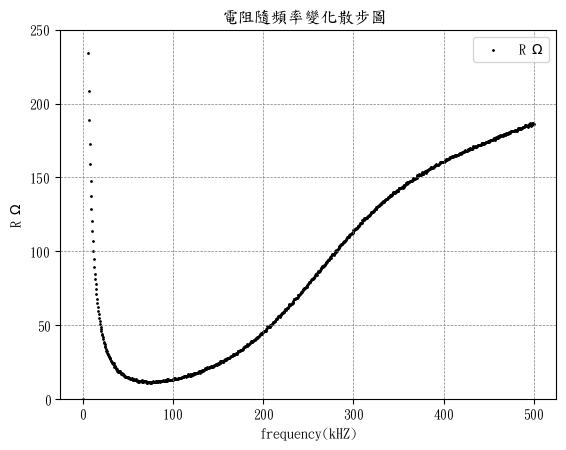

In [187]:
fig, ax= plt.subplots()

ax.set(xlabel = 'frequency(kHZ)', ylabel = r'R $\Omega$', 
       title = "電阻隨頻率變化散步圖 ")  
# ax.set_xlim(0, 20)

ax.set_ylim(0, 250)
ax.scatter(pi_10M_100[0]/1e3,
            R_pi_10M_100,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label = r"R $\Omega$",
            marker = "o")



plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()


In [204]:
#for smooth curve
a = low_10_1[0]/1e3
X_Y_Spline_1 = make_interp_spline(a, R_low_10_1)
low_10_1_ = np.linspace(a.min(), a.max(), 500)
R_low_10_1_  = X_Y_Spline_1(low_10_1_)

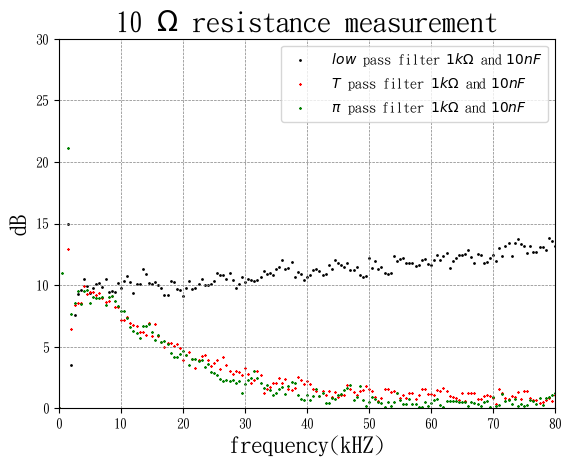

In [236]:
fig, ax= plt.subplots()

ax.set(xlabel = 'frequency(kHZ)', ylabel = 'dB', 
       title = r"10 $\Omega$ resistance measurement ")  
ax.title.set_size(20)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_ylim(0, 30)
ax.set_xlim(0, 80)

# for low pass

ax.scatter(low_10_1[0]/1e3,
            R_low_10_1,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $low$ pass filter $1k\Omega$ and$\ 10nF $",
            marker = "o")


# for T pass

ax.scatter(T_10_1[0]/1e3,
            R_T_10_1,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $T$ pass filter $1k\Omega$ and$\ 10nF $",
            marker = "x")

# for pi pass

ax.scatter(pi_10_1[0]/1e3,
            R_pi_10_1,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $\pi$ pass filter $1k\Omega$ and$\ 10nF $",
            marker = "*")


plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
# plt.savefig('C:\\qcodes\\personal_scripts\\HE\\4_wire_mes\only_filter\\1k_to_10n_4.png', 
#             dpi=2000, 
#             format='png')
plt.show()

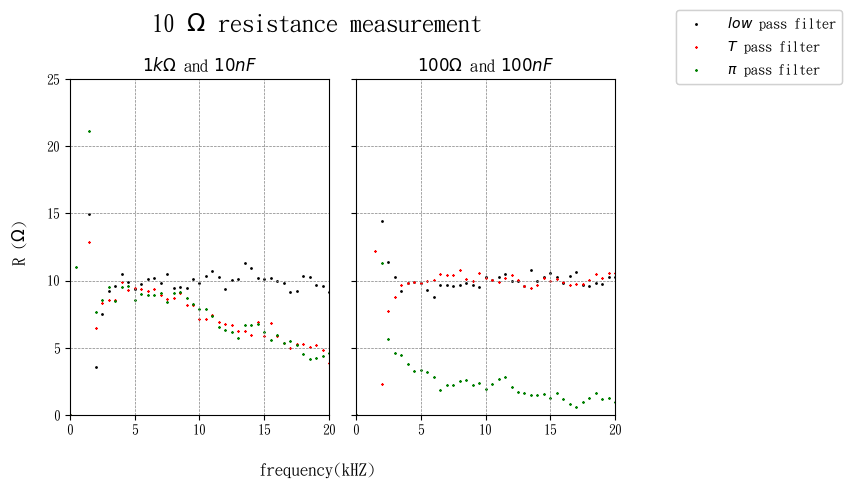

In [287]:
fig, (ax1,ax2)= plt.subplots(1,2, sharey='row')

fig.suptitle(r"10 $\Omega$ resistance measurement ", fontsize = 'xx-large')

ax1.set_title(r'$1k\Omega$ and$\ 10nF $')
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax1.set_ylim(0, 25)
ax1.set_xlim(0, 20)

ax2.set_title(r'$100\Omega$ and$\ 100nF $')
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
ax2.set_xlim(0, 20)


fig.supxlabel(r'frequency(kHZ)')
fig.supylabel(r'R ($\Omega$)')

# for low pass

ax1.scatter(low_10_1[0]/1e3,
            R_low_10_1,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $low$ pass filter",
            marker = "o")


# for T pass

ax1.scatter(T_10_1[0]/1e3,
            R_T_10_1,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $T$ pass filter",
            marker = "x")

# for pi pass

ax1.scatter(pi_10_1[0]/1e3,
            R_pi_10_1,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $\pi$ pass filter",
            marker = "*")

# for 100 ohm, 100nF

# for low pass

ax2.scatter(low_10_100[0]/1e3,
            R_low_10_100,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            
            marker = "o")


# for T pass

ax2.scatter(T_10_100[0]/1e3,
            R_T_10_100,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
           
            marker = "x")

# for pi pass

ax2.scatter(pi_10_100[0]/1e3,
            R_pi_10_100,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
           
            marker = "*")

ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
lg = fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('C:\\qcodes\\personal_scripts\\HE\\4_wire_mes\\10_ohm3.png', 
            dpi=2000, 
            bbox_extra_artists=(lg,),
            format='png')
plt.show()

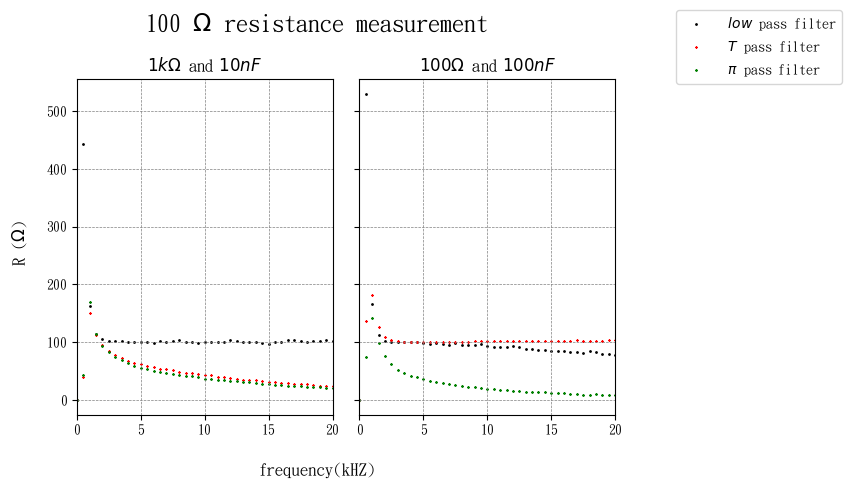

In [281]:
fig, (ax1,ax2)= plt.subplots(1,2, sharey='row')

fig.suptitle(r"100 $\Omega$ resistance measurement ", fontsize = 'xx-large')

ax1.set_title(r'$1k\Omega$ and$\ 10nF $')
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
# ax1.set_ylim(0, 150)
ax1.set_xlim(0, 20)

ax2.set_title(r'$100\Omega$ and$\ 100nF $')
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
ax2.set_xlim(0, 20)


fig.supxlabel(r'frequency(kHZ)')
fig.supylabel(r'R ($\Omega$)')

# for low pass

ax1.scatter(low_100_1[0]/1e3,
            R_low_100_1,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $low$ pass filter",
            marker = "o")


# for T pass

ax1.scatter(T_100_1[0]/1e3,
            R_T_100_1,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $T$ pass filter",
            marker = "x")

# for pi pass

ax1.scatter(pi_100_1[0]/1e3,
            R_pi_100_1,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $\pi$ pass filter",
            marker = "*")

# for 100 ohm, 100nF

# for low pass

ax2.scatter(low_100_100[0]/1e3,
            R_low_100_100,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            
            marker = "o")


# for T pass

ax2.scatter(T_100_100[0]/1e3,
            R_T_100_100,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
           
            marker = "x")

# for pi pass

ax2.scatter(pi_100_100[0]/1e3,
            R_pi_100_100,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
           
            marker = "*")

ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('C:\\qcodes\\personal_scripts\\HE\\4_wire_mes\\100_ohm3.png', 
            dpi=2000, 
            format='png')
plt.show()

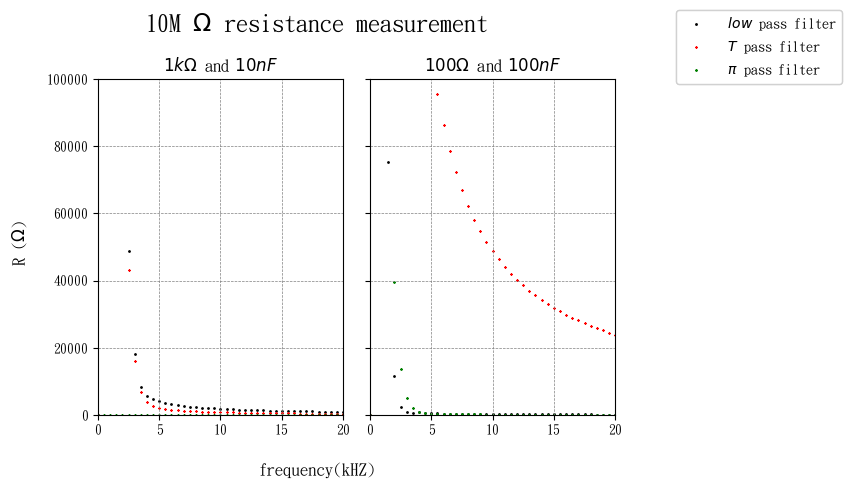

In [280]:
fig, (ax1,ax2)= plt.subplots(1,2, sharey='row')

fig.suptitle(r"10M $\Omega$ resistance measurement ", fontsize = 'xx-large')

ax1.set_title(r'$1k\Omega$ and$\ 10nF $')
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax1.set_ylim(0, 10e4)
ax1.set_xlim(0, 20)

ax2.set_title(r'$100\Omega$ and$\ 100nF $')
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
ax2.set_xlim(0, 20)


fig.supxlabel(r'frequency(kHZ)')
fig.supylabel(r'R ($\Omega$)')

# for low pass

ax1.scatter(low_10M_1[0]/1e3,
            R_low_10M_1,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $low$ pass filter",
            marker = "o")


# for T pass

ax1.scatter(T_10M_1[0]/1e3,
            R_T_10M_1,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $T$ pass filter",
            marker = "x")

# for pi pass

ax1.scatter(pi_10M_1[0]/1e3,
            R_pi_10M_1,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
            label =r" $\pi$ pass filter",
            marker = "*")

# for 100 ohm, 100nF

# for low pass

ax2.scatter(low_10M_100[0]/1e3,
            R_low_10M_100,
            c = "k",                                  
            s = 1,                                  
            alpha = 1,
            
            marker = "o")


# for T pass

ax2.scatter(T_10M_100[0]/1e3,
            R_T_10M_100,
            c = "r",                                  
            s = 1,                                  
            alpha = 1,
           
            marker = "x")

# for pi pass

ax2.scatter(pi_10M_100[0]/1e3,
            R_pi_10M_100,
            c = "g",                                  
            s = 1,                                  
            alpha = 1,
           
            marker = "*")

ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
lg = fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('C:\\qcodes\\personal_scripts\\HE\\4_wire_mes\\10M_ohm3.png', 
            dpi=2000, 
            bbox_extra_artists=(lg,),
            format='png')
plt.show()

In [ ]:
np.argmax(R_sap_y)
print(fre_x[320])

In [ ]:
print(lockin_1.X(), lockin_1.Y(),lockin_1.R(), lockin_1.P())

In [ ]:
step=10
for i in range (step):
    print(keithley_2.amplitude())
    sleep(1)

In [ ]:
K213.voltage1(0)
# K213.voltage2(0)
# K213.voltage3(0.1)
# K213.voltage4(0.1)
# snapshot_of_station = station.snapshot()
# pprint(snapshot_of_station)

In [ ]:
station.snapshot(update=True);

In [ ]:
snapshot_of_station = station.snapshot()
print(snapshot_of_station)

In [ ]:
hghfgggghtdh2421b yfy1

## DAC rates

In [ ]:
# ivvi.dac1.step = 50
# ivvi.dac1.inter_delay = 0.05
# ivvi.dac2.step = 50
# ivvi.dac2.inter_delay = 0.05
# ivvi.dac3.step = 1
# ivvi.dac3.inter_delay = 0.2

## Database initialisation

Next, we create a qcodes database. If you want to use an existing one, set reuse 'True'. Database is created in the "data" folder. Sample folder is the same as for this script

In [ ]:
reuse = True
%run C:\\qcodes\init_database.py {reuse}


# Scaled parameters

It is more convenient to use meaningful parameters with correct units

In [ ]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters

In [ ]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1000 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

## IVVI rack parameters - update here during measuerements

In [ ]:
set_resistance = 10e6
set_V_amp = lockin_1.amplitude()
set_current = set_V_amp/set_resistance

Irange.set(set_current)
Vrange.set(10e-3)
TGrange.set(15)
Gain_K1.set(1)
Gain_K2.set(1)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())
#division parameters are updated automatically


## DC parameters
Check that devicies are correct!

In [ ]:
# appl_current = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_current = ScaledParameter(K213.voltage, division = Irange_division, name = 'appl_current', unit = 'A')
appl_voltage = ScaledParameter(ivvi.dac2, division = Vrange_division, name = 'appl_voltage', unit = 'V')
appl_TG = ScaledParameter(ivvi.dac3, division = TGrange_division, name = 'appl_TG', unit = 'V')

meas_voltage_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')
meas_voltage_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')

meas_leakage = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

meas_current_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_current_K1', unit = 'A')
meas_current_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')

station.add_component(appl_current)
station.add_component(appl_voltage)
station.add_component(appl_TG)
station.add_component(meas_voltage_K1)
station.add_component(meas_voltage_K2)
station.add_component(meas_leakage)
station.add_component(meas_current_K1)
station.add_component(meas_current_K2)

## AC parameters

In [ ]:
appl_current_AC = ScaledParameter(lockin_1.amplitude, 
                                  division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')

appl_voltage_AC = ScaledParameter(lockin_1.amplitude, 
                                  division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')

station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')
meas_current_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_current_Lockin1', unit = 'A')

# meas_voltage_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_voltage_Lockin2', unit = 'V')
# meas_current_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_current_Lockin2', unit = 'A')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)

# station.add_component(meas_voltage_AC_L2)
# station.add_component(meas_current_AC_L2)

meas_voltage_AC_L1_R = ScaledParameter(lockin_1.R, division = Gain_L1, name = 'meas_voltage_R_Lockin1', unit = 'V')
# meas_voltage_AC_L2_R = ScaledParameter(lockin_2.R, division = Gain_L2, name = 'meas_voltage_R_Lockin2', unit = 'V')

station.add_component(meas_voltage_AC_L1_R)
# station.add_component(meas_voltage_AC_L2_R)

In [ ]:
appl_frequency = ScaledParameter(lockin_1.frequency, 
                                  division = 1, name = 'appl_frequency', unit = 'Hz')

station.add_component(appl_frequency)

## Another useful example: magnet using dac (Janis)

>2231.2 G per A => 0.22312 T per A<br>
I source 10mA per V => 1e-5 A per 1mV<br>
result: 0.22312 T/A * 1e-5 A/mV

In [ ]:
#check Janis and VectorJanis!
#magnetic_field = ScaledParameter(ivvi.dac3, gain = 0.22312e-5, name = 'magnetic_field_dac', unit = 'T')
#station.add_component(magnetic_field)

In [ ]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
    current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

def get_R_from_IV_2(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

# Parameter to get R from fast IV

In [ ]:
I_lim_r_IV = set_current
N_point_r_IV = 40
delay_r_IV = 0.02

In [ ]:
R_val_2 = None

def get_R_from_IV_1():
    global R_val_2
    I_vals = np.linspace(-I_lim_r_IV, I_lim_r_IV, N_point_r_IV)
    V_vals_1 = np.zeros_like(I_vals)
    V_vals_2 = np.zeros_like(I_vals)
    appl_current_AC.post_delay = delay_r_IV
    
    for i, I_val in enumerate(I_vals):
        appl_current_AC(I_val)
        V_vals_1[i] = meas_voltage_K1()
        V_vals_2[i] = meas_voltage_K2()
        
    fit_values_1 = np.polyfit(I_vals,V_vals_1,1)
    fit_values_2 = np.polyfit(I_vals,V_vals_2,1)
    
    R_val_2 = fit_values_2[0]
    
    return fit_values_1[0]

def get_R_from_IV_2():
    global R_val_2
    if R_val_2:
        last_val = R_val_2
        R_val_2 = None
    else:
        get_R_from_IV_1()
        last_val = R_val_2
        R_val_2 = None
    
    return last_val

In [ ]:
import time
start_time = time.time()
get_R_from_IV_1()
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
r_from_IV_1 = Parameter('r_from_IV_1', 
                       label='resistance from fast IV K1 fit', unit='Ohm', 
                       set_cmd=None, get_cmd=get_R_from_IV_1)

r_from_IV_2 = Parameter('r_from_IV_2', 
                       label='resistance from fast IV K2 fit', unit='Ohm', 
                       set_cmd=None, get_cmd=get_R_from_IV_2)

# Fridge measurements

In [ ]:
time = ElapsedTimeParameter('time')

def He_limit(time, measured_values):
    return measured_values[0].get() > 31

In [ ]:
time = ElapsedTimeParameter('time')

def temp_limit(time, measured_values):
    return measured_values[2].get() < 0.31

In [ ]:
exp = qc.new_experiment('cool_down_to_base_vs_time', sample_name='fridge VJ')
time.reset_clock()
dataid = measure_until(time, temp_limit, 3, lakeshore.A.temperature, lakeshore.B.temperature, lakeshore.C.temperature)

In [ ]:
plot_by_id(3)

In [ ]:
time = ElapsedTimeParameter('time')

def time_limit_3_days(time, measured_values):
    return time() > 60 * 60 * 24 * 3

In [ ]:
exp = qc.new_experiment('fridge at base', sample_name='fridge VJ')
time.reset_clock()
dataid = measure_until(time, time_limit_3_days, 60 * 5, 
                       lakeshore.A.temperature, lakeshore.B.temperature, lakeshore.C.temperature, 
                       level_meter.lastval )

# Simple IVs

In [ ]:
# cryomag.channel_B.field(0)
# magnetic_field_yoko(-1.07e-3)
# magnetic_field_yoko(0)

In [ ]:
R=lockin_1.X()/(lockin_1.amplitude()/1e7)
print(R)

In [ ]:
appl_frequency

In [ ]:
# appl_TG(0.7)
# sleep(10)
appl_current(-0.5e-6)
sleep(1)
station.snapshot(update=True);
exp = qc.new_experiment('IV', sample_name='JJ1_JJ1(K1)_JJ2(K2)')
dataid = do1d(appl_current, -0.5e-6, 0.5e-6, 1001, 0.02, meas_voltage_K1, meas_voltage_K2)
# ivvi.set_dacs_zero()
appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
# print(get_R_from_IV_2(dataid))

In [ ]:
print(get_R_from_IV(dataid))
print(get_R_from_IV_2(dataid))

In [ ]:
appl_current_AC(10e-9)
appl_current(-1e-6)
sleep(10)
station.snapshot(update=True);
exp = qc.new_experiment('IV + AC', sample_name='TL1_fL_finger')
dataid = do1d(appl_current, -1e-6, 1e-6, 501, 3, 
              meas_voltage_K1, meas_voltage_AC_L1, lockin_1.P, 
              meas_voltage_K2, meas_voltage_AC_L2, lockin_2.P)
# plot_by_id(dataid)
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)

# Zero Everything

In [ ]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)
# ivvi.print_readable_snapshot(update=True)

# Gate simple sweeps

In [ ]:
exp = qc.new_experiment('I_vs_Vtg', sample_name='BL1')

appl_voltage(1e-3)

start_gate = 0.0
stop_gate = 0.45
num_points = 500
leak_threshold = 1e-9

#Register independent parameters
meas = Measurement()
meas.register_parameter(appl_TG)
appl_TG.post_delay = 0.05

#Register dependent parametrs
param_meas = [meas_current_K1, meas_leakage]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(appl_TG,))
    output.append([parameter, None])

#Add action at the end
meas.add_after_run(ivvi.set_dacs_zero, ())

appl_TG(start_gate)
sleep(2)

#Start measuremnts
with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start_gate, stop_gate, num_points)):
        appl_TG(set_point)
        sleep(0.05)
        if np.abs(meas_leakage()) > leak_threshold:
            print('Leakage detected!')
            break
        sleep(0.05)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((appl_TG, appl_TG()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

In [ ]:
appl_TG(0)

In [ ]:
plot_by_id(dataid)

In [ ]:
appl_voltage(1e-3)
appl_TG(0)
sleep(2)
station.snapshot(update=True);
exp = qc.new_experiment('I_vs_Vgate_up', sample_name='JJ1_JJ5')
dataid1 = do1d(appl_TG, 0, 0.4, 400, 0.1, meas_current_K1)
# plot_by_id(dataid1)

# station.snapshot(update=True);
exp = qc.new_experiment('I_vs_Vgate_down', sample_name='JJ1_JJ5')
dataid2 = do1d(appl_TG, 0.4, 0.0, 400, 0.1, meas_current_K1)
# plot_by_id(dataid2)

ivvi.set_dacs_zero()

In [ ]:
fig, ax = plt.subplots(1)
axes, cbaxes = plot_by_id(dataid1, axes=[ax], label = 'up')
axes, cbaxes = plot_by_id(dataid2, axes=[ax], label = 'down')
plt.legend(fontsize = 14)
plt.savefig('../plots/JJ1_JJ5_hyst1.png')

# JJ measurement

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-5e-3)

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-5e-3)
appl_current(-0.5e-6)
sleep(5)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs B', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(cryomag.channel_A.field, -5e-3, 5e-3, 201, 2, appl_current, -0.5e-6, 0.5e-6, 501, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
cryomag.channel_A.field(0)

plot_by_id(dataid)

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-20e-3)
appl_current(-0.5e-6)
sleep(60)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs B larger range', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(cryomag.channel_A.field, -20e-3, 20e-3, 401, 4, appl_current, -0.5e-6, 0.5e-6, 501, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
cryomag.channel_A.field(0)

plot_by_id(dataid)

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-5e-3)
appl_current(-0.5e-6)
sleep(60)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs B small range', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(cryomag.channel_A.field, -5e-3, 5e-3, 401, 4, appl_current, -0.5e-6, 0.5e-6, 801, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
cryomag.channel_A.field(0)

plot_by_id(dataid)

In [ ]:
cryomag.channel_A.field(-0.3e-3)

In [ ]:
appl_TG(0.2)
appl_current(-0.5e-6)
sleep(60)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs Vg', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(appl_TG, 0.2, 0.4, 21, 3, appl_current, -0.5e-6, 0.5e-6, 801, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
appl_TG(0.35)

plot_by_id(dataid)

# JJ measurements for MAR

In [ ]:
cryomag.channel_A.field()

In [ ]:
appl_TG(0.4)

In [ ]:
lockin_1.amplitude(0.004)
appl_current(-20e-6)
sleep(1)
station.snapshot(update=True);

exp = qc.new_experiment('IV', sample_name='JJ1_JJ_1')
dataid = do1d(appl_current, -20e-6, 20e-6, 501, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
appl_current(0)
plot_by_id(dataid)

In [ ]:
#determine lockin sensitivity
R = 500 #Ohms
I_AC = 100e-9
V_real = R * I_AC
V_lockin = R * I_AC * Gain_L1()
print(V_lockin)

In [ ]:
lockin_1.sensitivity(0.01)

In [ ]:
lockin_1.sensitivity.vals

In [ ]:
2000 / 60

In [ ]:
appl_current(-20e-6)
appl_current_AC(100e-9)

In [ ]:
keithley_1.amplitude()

In [ ]:
appl_current_AC(100e-9)
appl_current(-20e-6)
sleep(10)
station.snapshot(update=True);
exp = qc.new_experiment('IV + AC', sample_name='JJ1_JJ_3')
dataid = do1d(appl_current, -20e-6, 20e-6, 2001, 1, meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_R)
# ivvi.set_dacs_zero()
appl_current(0)
lockin_1.amplitude(0.004)
plot_by_id(dataid)

In [ ]:
appl_current(0)
lockin_1.amplitude(0.004)

# Hall measurements

In [ ]:
appl_gate_1(1)
appl_TG(0.4)

In [ ]:
appl_TG(0.4)

In [ ]:
appl_gate_1(1)
appl_TG(0.4)
appl_current(100e-9)
sleep(30)


station.snapshot(update=True);

exp = qc.new_experiment('Vu_vs_gate_field, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do2d(cryomag.channel_B.field, 0, 5, 41, 10, appl_gate_1, 1, 1.75, 120, 1, meas_voltage_K1)

appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
appl_gate_1(1.1)

In [ ]:
appl_gate_1(1.1)
appl_TG(0.4)
appl_current_AC(5e-9)
appl_current(0)
sleep(30)


station.snapshot(update=True);

exp = qc.new_experiment('ACVd_vs_gate B=5T, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do1d(appl_gate_1, 1.1, 1.75, 120, 3, meas_voltage_AC_L1, meas_voltage_AC_L1_R)
lockin_1.amplitude(0.004)
appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
appl_gate_1(1.1)
appl_TG(0.4)
lockin_1.amplitude(0.004)
appl_current(0)
sleep(10)


station.snapshot(update=True);

exp = qc.new_experiment('fast_DC_Vd_vs_gate B=5T, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do1d(appl_gate_1, 1.1, 1.75, 120, 1, r_from_IV_1)
lockin_1.amplitude(0.004)
appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
lockin_1.amplitude(0.004)

In [ ]:
appl_gate_1(1.1)
appl_TG(0.4)
appl_current_AC(5e-9)
appl_current(0)
sleep(30)


station.snapshot(update=True);

exp = qc.new_experiment('ACVd_vs_gate_vs_B, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do2d(cryomag.channel_B.field, 5, 4, 11, 5, appl_gate_1, 1.1, 1.75, 120, 3, meas_voltage_AC_L1, meas_voltage_AC_L1_R)
lockin_1.amplitude(0.004)
appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
14e3 * 300e-9 *1e3

In [ ]:
lockin_1.amplitude(0.004)
appl_gate_1(1.1)
appl_TG(0.4)

for B_field in [3,4,5,6]:
    appl_gate_1(1.1)
    cryomag.channel_B.field(B_field)
    appl_current(-300e-9)
    sleep(60)
    
    station.snapshot(update=True);

    exp = qc.new_experiment('Vd_vs_I_gate, Vsplit = 0.4, B={}'.format(B_field), sample_name='TR1_left_half')

    dataid = do2d( appl_gate_1, 1.1, 1.75, 120, 3, appl_current, -300e-9, 300e-9, 1201, 0.05, meas_voltage_K1)
    
    plot_by_id(dataid)

In [ ]:
#Extra experiment at B=3.5
lockin_1.amplitude(0.004)
appl_gate_1(1.1)
appl_TG(0.4)

for B_field in [3.5]:
    appl_gate_1(1.1)
    cryomag.channel_B.field(B_field)
    appl_current(-300e-9)
    sleep(60)
    
    station.snapshot(update=True);

    exp = qc.new_experiment('Vd_vs_I_gate, Vsplit = 0.4, B={}'.format(B_field), sample_name='TR1_left_half')

    dataid = do2d( appl_gate_1, 1.1, 1.75, 120, 3, appl_current, -300e-9, 300e-9, 1201, 0.05, meas_voltage_K1)
    
    plot_by_id(dataid)

In [ ]:
# Pinch off measurement

lockin_1.amplitude(0.004)
appl_gate_1(1.1)
appl_TG(0.4)

for B_field in [3,4,5,6]:
    appl_gate_1(1.1)
    cryomag.channel_B.field(B_field)
    appl_current(-300e-9)
    sleep(60)
    
    station.snapshot(update=True);

    exp = qc.new_experiment('Vd_vs_I_gate, Vsplit = 0.4, B={}'.format(B_field), sample_name='TR1_left_half')

    dataid = do2d( appl_gate_1, 1.1, 1.75, 120, 3, appl_current, -300e-9, 300e-9, 1201, 0.05, meas_voltage_K1)
    
    plot_by_id(dataid)

In [ ]:
appl_current(0)

# Split-gate in QH

In [ ]:
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(1e-3)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.5, 200, 1, meas_voltage_K1, meas_current_K2)

appl_voltage(0)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(1e-6) #1uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 120, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(1e-6) #1uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(5e-6) #5uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(10e-6) #10uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(5e-6) #5uV
appl_gate_1(1.1)
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_TG,splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do2d(appl_gate_1, 1.1, 1.75, 21, 3, appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
appl_gate_1(1.4)
plot_by_id(dataid)

In [ ]:
lockin_1.amplitude(0.004)
appl_TG(0)
appl_gate_1(1.4)

In [ ]:
temp = lakeshore.C.temperature()
while temp > 0.35:
    print('Waiting for base temp! current temp is {:.2f}K'.format(temp), end = '\r')
    sleep(1)
    temp = lakeshore.C.temperature()

In [ ]:
cryomag.B.field(5)

In [ ]:
for top_gate_val in np.linspace(1.7, 1.2, 6):
    appl_gate_1(top_gate_val)
    appl_TG(0.5) #split-gate
    appl_voltage(-4e-3)
    
    sleep(60)

    station.snapshot(update=True);

    exp = qc.new_experiment('I,Vd_vs_Vbias,splitgate, Vtg={}'.format(top_gate_val), sample_name='TR1_left_half')

    dataid = do2d(appl_TG, 0.5, -0.4, 101, 2, appl_voltage, -4e-3, 4e-3, 1201, 0.01, meas_voltage_K1, meas_current_K2)
    
    appl_voltage(0)
    appl_TG(0)

In [ ]:
appl_voltage(0)
appl_TG(0)

# JJ at high field

In [ ]:
appl_gate_1(0.4)

In [ ]:
station.snapshot(update=True);
exp = qc.new_experiment('IV B aprox 5T, TG=0.4V', sample_name='TR1_JJ')
dataid = do1d(appl_current, -10e-9, 10e-9, 101, 0.1, meas_voltage_K1)
# ivvi.set_dacs_zero()
appl_current(0)
plot_by_id(dataid)

In [ ]:
temp = lakeshore.C.temperature()
while temp > 0.35:
    print('Waiting for base temp! current temp is {:.2f}K'.format(temp), end = '\r')
    sleep(1)
    temp = lakeshore.C.temperature()

In [ ]:
appl_gate_1(0.3)
appl_current_AC(1e-9)
appl_current(0)
sleep(60)


station.snapshot(update=True);

exp = qc.new_experiment('ACVd_vs_gate B=5T, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do2d(cryomag.channel_B.field, 6, 1, 51, 5, appl_gate_1, 0.3, 1.7, 141, 3, meas_voltage_AC_L1, meas_voltage_AC_L1_R)

lockin_1.amplitude(0.004)
appl_current(0)

cryomag.channel_B.field(0)

appl_gate_1(0.3)
plot_by_id(dataid)

In [ ]:
cryomag.channel_B.field(3)

In [ ]:
for Bval in [6, 5, 4, 3]:

    cryomag.channel_B.field(Bval)

    appl_gate_1(0.4)
    appl_current_AC(1e-9)
    appl_current(-200e-9)
    sleep(60)


    station.snapshot(update=True);

    exp = qc.new_experiment('AC IV vs Vg, B = {:.2f}'.format(Bval), sample_name='TR1_JJ')

    dataid = do2d(appl_gate_1, 0.4, 1.7, 40, 3, appl_current, -200e-9, 200e-9, 21, 3,
                  meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_R)

    appl_current(0)
    appl_gate_1(0.4)
    
lockin_1.amplitude(0.004)
appl_gate_1(0.4)
cryomag.channel_B.field(0)

# Temp dependence

In [ ]:
# lakeshore.output_1.output_range('off')
lakeshore.output_1.setpoint(45.0)
# lakeshore.output_1.input_channel('A')
lakeshore.output_1.output_range('2.5W')

In [ ]:
print('Temps: A= {:.2f}, B = {:.4f}, C ={:.4f}'.format(lakeshore.A.temperature(), lakeshore.B.temperature(), lakeshore.C.temperature()) )

In [ ]:
lockin_1.time_constant(1)
sleep(1)
appl_current_AC(2.5e-9)
appl_current(-8e-6)
sleep(9)

lakeshore.output_1.setpoint(0.3)
lakeshore.output_1.output_range('25mW')

sleep(6)

for set_temp in [0.3, 0.35, 0.4, 0.5, 0.6]:
    lakeshore.output_1.setpoint(set_temp)
    sleep(5)
    lakeshore.output_1.wait_until_set_point_reached(wait_cycle_time = 2, tolerance = 20e-3, wait_equilibration_time = 20)
    
    exp = qc.new_experiment('IV + AC across finger zero field T={}K'.format(set_temp), sample_name='TR1_fR')
    
    dataid = do1d(appl_current, -8e-6, 8e-6, 400, 2, meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_R, lockin_1.P, lakeshore.C.temperature)
    
    appl_current(-8e-6)
    sleep(5)
    
    
lockin_1.amplitude(0.004)
appl_current(0.0)
lakeshore.output_1.setpoint(0)
lakeshore.output_1.output_range('off')

In [ ]:
lakeshore.C.temperature()

In [ ]:
# time = ElapsedTimeParameter('time')

#note that here exit_condition takes two independent parameters and only then measured parameters
def temp_limit(temp, current, measured_values):
    return temp() < 0.33

appl_TG(2.0)
sleep(5)
appl_TG(1.2)
sleep(5)
    
gate_val = 1.5
appl_TG(gate_val)
appl_current(-300e-9)
sleep(10)

B_val = cryomag.channel_B.field()

station.snapshot(update=True);
exp = qc.new_experiment('IV_vs_temp_CD Vg = {}, B = {:.1f}'.format(gate_val, B_val), sample_name='TR2_fL')

dataid = do1d_until(lakeshore.C.temperature, temp_limit, 20, appl_current, -300e-9, 300e-9, 400, 0.05, 
                    meas_voltage_K1, meas_voltage_K2)

appl_current(0)

In [ ]:
def temp_limit(temp, current, measured_values):
    return temp() < 0.33


In [ ]:
for B_val, gate_val in zip([3, 4, 5, 5, 6, 6],[1.6, 1.8, 1.44, 2, 1.5, 1.6]):
    appl_TG(2.0)
    sleep(5)
    appl_TG(1.2)
    sleep(5)
    appl_TG(gate_val)
    cryomag.channel_B.field(B_val)
    
    lakeshore.output_1.output_range('2.5W')
    
    while lakeshore.A.temperature() < 44.5:
        sleep(5)
    
    sleep(60*4)
    lakeshore.output_1.output_range('off')
    sleep(60*4)
    
    if level_meter.lastval() < 14.5:
        print('He level critical!')
        cryomag.channel_B.write('SWEEP ZERO')
        break
    
    temp = lakeshore.C.temperature()
    while temp > 2.5:
        sleep(10)
        temp = lakeshore.C.temperature()
    
    appl_current(-400e-9)
    sleep(5)

    station.snapshot(update=True);
    exp = qc.new_experiment('IV_vs_temp_CD Vg = {}, B = {:.1f}'.format(gate_val, B_val), sample_name='TR2_N_4probes')

    dataid = do1d_until(lakeshore.C.temperature, temp_limit, 20, appl_current, -400e-9, 400e-9, 400, 0.05, 
                        meas_voltage_K1, meas_voltage_K2)

    appl_current(0)
    appl_TG(1.3)
    
# cryomag.channel_B.write('SWEEP ZERO')

In [ ]:
lockin_1.amplitude(0.004)

for B_val in [6, 5]:
    
    cryomag.channel_B.field(B_val)
    
    lakeshore.output_1.output_range('2.5W')
    
    while lakeshore.A.temperature() < 44.5:
        sleep(5)
    
    sleep(60*4)
    lakeshore.output_1.output_range('off')
    sleep(60*3)
    
    appl_TG(2.0)
    sleep(5)
    appl_TG(1.3)

    station.snapshot(update=True);
    exp = qc.new_experiment('DC_fit_vs_Vg_vs_temp_CD zero bias B = {:.1f}'.format(B_val), sample_name='TR2_fB')

    dataid = do1d_until(lakeshore.C.temperature, temp_limit, 5, appl_TG, 1.3, 2, 41, 3, 
                        r_from_IV_1, r_from_IV_2)
    appl_TG(1.3)
    
appl_current(0)

In [ ]:
appl_current_AC(5e-9)
appl_current(0)

for B_val in [5, 4, 3]:
    
    cryomag.channel_B.field(B_val)
    
    lakeshore.output_1.output_range('2.5W')
    
    while lakeshore.A.temperature() < 44.5:
        sleep(5)
    
    sleep(60*4)
    lakeshore.output_1.output_range('off')
    sleep(60*3)
    
    appl_TG(2.0)
    sleep(5)
    appl_TG(1.3)
    
    if level_meter.lastval() < 14.5:
        print('He level critical!')
        cryomag.channel_B.write('SWEEP ZERO')
        break
        

    station.snapshot(update=True);
    exp = qc.new_experiment('AC_vs_Vg_vs_temp_CD zero bias B = {:.1f}'.format(B_val), sample_name='TR2_fB')

    dataid = do1d_until(lakeshore.C.temperature, temp_limit, 5, appl_TG, 1.3, 2, 41, 3, 
                        meas_voltage_AC_L1, meas_voltage_AC_L2, meas_voltage_AC_L1_R, meas_voltage_AC_L2_R,
                        lockin_1.P, lockin_2.P)
    appl_TG(1.3)
    
# cryomag.channel_B.write('SWEEP ZERO')
lockin_1.amplitude(0.004)
station.snapshot(update=True);

In [ ]:
cryomag.channel_B.field(0)

In [ ]:
cryomag.channel_B.write('SWEEP ZERO')

In [ ]:
station.snapshot(update=True);

In [ ]:
appl_current(0)

# Test cells

In [ ]:
appl_voltage(0)
station.snapshot(update=True);
exp = qc.new_experiment('wire resistant', sample_name='wire')
dataid = do1d(appl_voltage, -3e-3, 3e-3, 101, 0.1, meas_current_K2)
# ivvi.set_dacs_zero()

plot_by_id(dataid)

In [ ]:
dataid = 153
dataset = qc.load_by_id(dataid)

In [ ]:
dataset.get_parameter_data().keys()

In [ ]:
voltage = dataset.get_parameter_data()['meas_current_K2']['appl_voltage']
current = dataset.get_parameter_data()['meas_current_K2']['meas_current_K2']

fit=np.polyfit(current,voltage,1)
fit